In [1]:
import abc
from collections import *
from dataclasses import dataclass
import enum
import gym
import numpy as np
from typing import *

%matplotlib inline
import imageio
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
'''
import pyglet
from pyglet.gl import *

window = pyglet.window.Window(width=300, height=200, display=None)
window.clear()

from gym.envs.classic_control import rendering
viewer = rendering.Viewer(screen_width, screen_height)
'''

# TODO - complexe... first without the maze, find the place to go

# TODO - move through a maze where 1 are blocked, 0 are free, and you must find the end
# TODO - use convolution net to find the right decision
# TODO - reward is -1 for each time your are in the maze

# TODO - make a custom space for actions / states?


class MazeEnv(gym.Env):
    def __init__(self, maze: np.ndarray, start_pos: Tuple[int, int]):
        self.maze: np.ndarray = np.array(maze)
        self.start_pos: Tuple[int, int] = start_pos
        self.end_positions: Set[Tuple[int, int]] = self._find_end_positions(maze)
        self.state = None # Must be immutable? I guess so
        self.action_space = gym.spaces.Discrete(4)
        self.observation_space = gym.spaces.MultiDiscrete(list(maze.shape))
    
    @property
    def done(self) -> bool:
        return self.state in self.end_positions
    
    def reset(self):
        self.state = self.start_pos
        return self.state
    
    def step(self, action):
        if self.done:
            raise Exception("Game is over")
        self._move(action)
        return self.state, -1, self.done, {}

    def _find_end_positions(self, maze):
        end_positions = set()
        h, w = self.maze.shape
        for i in range(h):
            for j in range(w):
                if self.maze[i, j] == 2:
                    end_positions.add((i, j))
                    self.maze[i, j] = 0
        return end_positions
    
    def _move(self, action):
        i, j = self.state
        h, w = self.maze.shape
        if action == 0:   # UP
            i = max(0, i - 1)
        elif action == 1: # DOWN
            i = min(h - 1, i + 1)
        elif action == 2: # LEFT
            j = max(0, j - 1)
        elif action == 3: # RIGHT
            j = min(w - 1, j + 1)
        if self.maze[i, j] == 0:
            self.state = (i, j)
    
    def render_state(self, zoom: int):
        h, w = self.maze.shape
        m = np.zeros((h, w, 3), 'uint8')
        for i in range(h):
            for j in range(w):
                if self.maze[i, j] == 1:
                    m[i, j, 0] = 255
        for i, j in self.end_positions:
            m[i, j, 1] = 255
        i, j = self.state
        m[i, j, 2] = 255
        image = Image.fromarray(m, 'RGB')
        image = image.resize((w * zoom, h * zoom))
        return image        

In [10]:
class ActionValues(abc.ABC):    
    @abc.abstractmethod
    def get_action_value(self, state, action) -> float:
        pass
    
    def get_best_action(self, state, actions):
        best_action = None
        best_score = float('-inf')
        for action in actions:
            score = self.get_action_value(state, action)
            if score > best_score:
                best_score = score
                best_action = action
        return best_action


class DiscreteActionValues(ActionValues):
    def __init__(self,default_value: float = 0., learning_rate: float = 0.1):
        # The default value might help in early exploration (if set in a higher value than what can possibly be)
        self.learning_rate = learning_rate
        self.values = defaultdict(lambda: defaultdict(lambda: default_value))
    
    def add(self, state, action, score: float) -> float:
        self.values[state][action] += self.learning_rate * (score - self.values[state][action])
    
    def get_action_value(self, state, action) -> float:
        return self.values[state][action]

    
class SumOfActionValues(ActionValues):
    def __init__(self, action_values: List[ActionValues]):
        self.action_values = action_values
    
    def get_action_value(self, state, action) -> float:
        return sum(vals.get_action_value(state, action) for vals in self.action_values)
    

class SARSA:
    def __init__(self,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1):
        self.q_values = DiscreteActionValues(default_value=default_value, learning_rate=learning_rate)
        self.reward_discount = reward_discount
        self.epsilon = epsilon
    
    def play_episode(self, env) -> float:
        total_reward = 0.
        state = env.reset()
        done = False
        while not done:
            action = self._behavior_policy_action(env, state)
            new_state, reward, done, info = env.step(action)
            new_action = self._target_policy_action(env, new_state)
            score = reward + self.reward_discount * self.q_values.get_action_value(new_state, new_action)
            self.q_values.add(state, action, score)
            total_reward += reward
            state = new_state
        return total_reward
    
    def get_action(self, env, state):
        return self._target_policy_action(env, state)
    
    def _target_policy_action(self, env, state):
        return self._behavior_policy_action(env, state)
    
    def _behavior_policy_action(self, env, state):
        if self.epsilon > 0. and np.random.random() < self.epsilon:
            return env.action_space.sample()
        return self.q_values.get_best_action(state, range(env.action_space.n))


class QLearning(SARSA):
    def __init__(self,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1):
        super().__init__(default_value=default_value, learning_rate=learning_rate, reward_discount=reward_discount, epsilon=epsilon)
    
    def _target_policy_action(self, env, state):
        return self.q_values.get_best_action(state, range(env.action_space.n))
    

class DoubleQLearning:
    def __init__(self,
                 default_value: float = 0.,
                 learning_rate: float = 0.1,
                 reward_discount: float = 1.,
                 epsilon: float = 0.1):
        self.q_values = [
            DiscreteActionValues(default_value=default_value, learning_rate=learning_rate),
            DiscreteActionValues(default_value=default_value, learning_rate=learning_rate)]
        self.q_values_sum = SumOfActionValues(self.q_values)
        self.reward_discount = reward_discount
        self.epsilon = epsilon
    
    def play_episode(self, env) -> float:
        total_reward = 0.
        state = env.reset()
        done = False
        
        while not done:
            action = self._behavior_policy_action(env, state)
            new_state, reward, done, info = env.step(action)
            
            which_q = np.random.randint(0, 2)
            q1 = self.q_values[which_q]
            q2 = self.q_values[1-which_q]
            new_action = q1.get_best_action(new_state, range(env.action_space.n))
            score = reward + self.reward_discount * q2.get_action_value(new_state, new_action)
            q2.add(state, action, score)
            
            total_reward += reward
            state = new_state
        return total_reward
    
    def get_action(self, env, state):
        return self.q_values_sum.get_best_action(state, range(env.action_space.n))
    
    def _behavior_policy_action(self, env, state):
        if self.epsilon > 0. and np.random.random() < self.epsilon:
            return env.action_space.sample()
        return self.q_values_sum.get_best_action(state, range(env.action_space.n))
    
    
"""
Training Loop
"""


class RunningAverage:
    def __init__(self):
        self.average = 0.
        self.count = 0
    
    def add(self, value):
        self.average += 1 / (self.count + 1) * (value - self.average)
        self.count += 1
    
    def reset(self):
        average = self.average
        self.average = 0.
        self.count = 0
        return average
    
    def get(self):
        return self.average


def train_agent(env, agent, nb_episodes: int):
    episodes = []
    averages = []
    running_average = RunningAverage()
    temperature_decrease_period = nb_episodes // 21
    temperature_decrease = agent.epsilon / 20
    for episode in range(1, nb_episodes + 1):
        reward = agent.play_episode(env)
        running_average.add(reward)
        if episode % temperature_decrease_period == 0:
            episodes.append(episode)
            averages.append(running_average.reset())
            print("Episode", episode, ":", averages[-1], " (epsilon " + str(agent.epsilon) + ")")
            agent.epsilon -= temperature_decrease
    return episodes, averages


def demo_agent(env, agent, gif_name: str):
    images = []
    state = env.reset()
    done = False
    while not done:
        action = agent.get_action(env, state)
        images.append(env.render_state(10))
        state, reward, done, info = env.step(action)
    images.append(env.render_state(10))
    imageio.mimsave(gif_name, images)

Episode 23 : -616.6956521739131  (epsilon 0.1)
Episode 46 : -303.695652173913  (epsilon 0.095)
Episode 69 : -219.86956521739128  (epsilon 0.09)
Episode 92 : -177.69565217391303  (epsilon 0.08499999999999999)
Episode 115 : -144.0434782608696  (epsilon 0.07999999999999999)
Episode 138 : -121.95652173913042  (epsilon 0.07499999999999998)
Episode 161 : -105.08695652173913  (epsilon 0.06999999999999998)
Episode 184 : -94.30434782608695  (epsilon 0.06499999999999997)
Episode 207 : -82.21739130434783  (epsilon 0.05999999999999998)
Episode 230 : -75.08695652173913  (epsilon 0.05499999999999998)
Episode 253 : -67.5217391304348  (epsilon 0.04999999999999998)
Episode 276 : -61.91304347826085  (epsilon 0.044999999999999984)
Episode 299 : -56.913043478260875  (epsilon 0.03999999999999999)
Episode 322 : -51.69565217391303  (epsilon 0.03499999999999999)
Episode 345 : -49.30434782608695  (epsilon 0.02999999999999999)
Episode 368 : -45.695652173913054  (epsilon 0.024999999999999988)
Episode 391 : -44.2

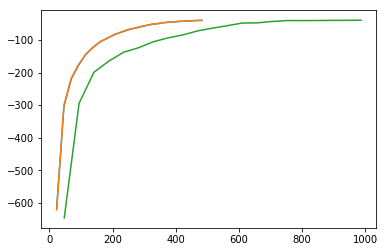

In [ ]:
maze = MazeEnv(
    maze=np.array([[0, 0, 0, 1, 0, 0, 0, 0, 0],
                   [0, 1, 0, 1, 0, 1, 1, 0, 1],
                   [0, 1, 1, 1, 0, 1, 0, 0, 0],
                   [0, 0, 0, 1, 0, 1, 1, 1, 0],
                   [1, 1, 0, 1, 0, 0, 1, 0, 0],
                   [0, 1, 0, 1, 1, 0, 1, 0, 1],
                   [0, 0, 0, 1, 0, 0, 1, 0, 0],
                   [1, 0, 1, 1, 0, 1, 1, 1, 0],
                   [0, 0, 0, 0, 0, 0, 1, 2, 0]]),
    start_pos=(0, 0)
)

sarsa = SARSA(default_value = 0., learning_rate = 0.1, reward_discount = 1., epsilon = 0.1)
episodes, averages = train_agent(env=maze, agent=sarsa, nb_episodes=500)
plt.plot(episodes, averages)

print("-" * 50)

qlearning = QLearning(default_value = 0., learning_rate = 0.1, reward_discount = 1., epsilon = 0.1)
episodes, averages = train_agent(env=maze, agent=qlearning, nb_episodes=500)
plt.plot(episodes, averages)

print("-" * 50)

double_q = DoubleQLearning(default_value = 0., learning_rate = 0.1, reward_discount = 1., epsilon = 0.1)
episodes, averages = train_agent(env=maze, agent=double_q, nb_episodes=1000)
plt.plot(episodes, averages)

plt.show()
demo_agent(maze, sarsa, gif_name='6_maze_sarsa.gif')
demo_agent(maze, qlearning, gif_name='6_maze_qlearning.gif')
demo_agent(maze, double_q, gif_name='6_maze_double_q.gif')